作为一门实验性学科，深度学习通常需要反复的实验和结果论证。在现在和将来，是否有海量的数据资源和强大的计算资源，这是决定学界和业界深度学习和人工智能发展的关键因素。通常情况下，获取海量的数据资源对于企业而言并非易事，尤其是对于像医疗等特定领域，要想做一个基于深度学习的医学影像的自动化诊断系统，大量且高质量的打标数据非常关键。但通常而言，莫说高质量，就是想获取大量的影像数据就已困难重重。

**迁移学习**
> 定义
>> 利用数据、任务或模型之间的**相似性**，将在旧的领域学习过或**训练好的模型**，**应用于新的领域**这样的一个过程。

> 使用迁移学习的主要原因
>> **没有海量的数据资源或强大的 GPU 计算资源**来训练一个鲁棒性很强的模型。

> 迁移学习的使用场景如下:
>> 假设有两个任务系统 A 和 B，任务 A 拥有海量的数据资源且已训练好，但并不是我们的目标任务，任务 B 是我们的目标任务，但数据量少且极为珍贵，这种场景便是典型的迁移学习的应用场景。那究竟什么时候使用迁移学习是有效的呢？对此笔者不敢武断地下结论。但必须如前文所言，新的任务系统和旧的任务系统必须在数据、任务和模型等方面存在一定的相似性，你将一个训练好的语音识别系统迁移到放射科的图像识别系统上，恐怕结果不会太妙。所以，要判断一个迁移学习应用是否有效，最基本的原则还是要遵守，即**任务 A 和任务 B 在输入上有一定的相似性，即两个任务的输入属于同一性质，要么同是图像、要么同是语音或其他**，这便是前文所说到的任务系统的相似性的含义之一。

> 迁移学习的使用方法
>> **finetune**，即微调，简单而言就是将别人训练好的网络拿来进行简单修改用于自己的学习任务。在实际操作中，通常用预训练的网络权值对自己网络的权值进行初始化，以代替原先的随机初始化。\
>>  **fixed feature extractor**，即将预训练的网络作为新任务的特征提取器，在实际操作中通常将网络的前几层进行冻结，只训练最后的全连接层，这时候预训练网络便是一个特征提取器。


 keras 为我们提供了经典网络在 ImageNet 上为我们训练好的预训练模型，预训练模型的基本信息如下表所示：
    ![在这里插入图片描述](https://img-blog.csdnimg.cn/20200610000010853.jpg?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L0lfYW1fYV9idWdlcg==,size_16,color_FFFFFF,t_70)

使用的试验数据来自于罗大钧在 cos 统计之都上的分享，数据可于此处下载：
https://pan.baidu.com/s/1jIMOc1S
![在这里插入图片描述](https://img-blog.csdnimg.cn/20200610000255267.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L0lfYW1fYV9idWdlcg==,size_16,color_FFFFFF,t_70)

## 处理数据

In [76]:
import numpy as np 
import os,cv2
path='../../samples/flower_photos/flower_photos/'
items=[label for label in os.listdir(path) if os.path.isdir(path+label)]
data,labels=[],[]
img=224
for id,v in enumerate(items):
    N=60 
    for i,name in enumerate(os.listdir(path+v)):
        if (i>N):break  
        p=os.path.join(path,v,name)
#         将图片缩放大小为 224x224x3
        resize=cv2.resize(cv2.imread(p),(img,img))
        data+=[resize]
        labels+=[id]
# 标准化  
data=np.array(data)/255
labels=np.array(labels)
data.shape 
# one_hot 
labels=np.eye(5)[labels]
labels.shape,data.shape

((305, 5), (305, 224, 224, 3))

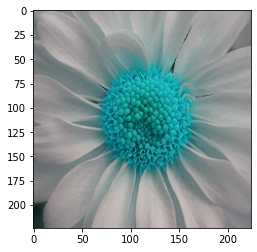

In [74]:
s=data[0]
from matplotlib import pyplot as plt 
plt.imshow(s)
plt.show()

In [72]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(data,labels,test_size=.3)
X_train.shape,X_test.shape

((213, 224, 224, 3), (92, 224, 224, 3))

## 基于resnet50 的迁移学习模型
试验模型的基本策略就是使用预训练模型的权重作为特征提取器，将预训练的权重进行冻结，只训练自己自定义的全连接层。

In [73]:
from keras.applications import ResNet50 
from keras.layers import Dense,Dropout,Flatten
from keras.models import Model
model_i=ResNet50(include_top=False,weights='imagenet',input_shape=(img,img,3))
for layer in model_f.layers:
    # 冻结：ResNet50权重不在训练，直接使用Keras训练好的
    layer.trainable=False
model_o=Flatten()(model_i.output)
model_o=Dense(128,activation='relu')(model_o)
model_o=Dropout(.5)(model_o)
model_o=Dense(5,activation='softmax')(model_o)
model=Model(inputs=model_i.input,outputs=model_o)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.fit(X_train,y_train,batch_size=128,epochs=6)

D:\software\Python37\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Exception: URL fetch failure on https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5 : None -- [WinError 10060] 由于连接方在一段时间后没有正确答复或连接的主机没有反应，连接尝试失败。

model.evaluate(X_test, y_test, verbose=0)